In [1]:
import csv
import pandas as pd
import numpy as np
import os
import shutil
from glob import glob
import math
#TSFRESH
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#ROC
import matplotlib.pyplot as plt  
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score 

In [2]:
# Convert raw data file to trip record files

def rawToRecord():
    print("Starting [rawToRecord]...")
    # **Modify List of Input Files:** filename1-part1.csv, filename2-part2.csv
    files=["part-0001-*.csv"] 
    for filename in files:
        file = pd.read_csv(filename, error_bad_lines=False, low_memory=False)
        for i, x in file.groupby('bookingID'):
            if os.path.exists(str(i).join(".csv")):
                x.to_csv('{}.csv'.format(i), index=False, mode='a') 
            else:
                x.to_csv('{}.csv'.format(i), index=False, mode='w')
    print("Finish [rawToRecord]...")

In [3]:
# Categories trip record files based on label (safe or dangerous driving)

def splitRecord():

    print("Starting [splitRecord]...")
    files = []
    files2= []

    truth = pd.read_csv("label.csv", error_bad_lines=False)
    total_rows = len(truth['bookingID'])
    for i in range(total_rows):
        if (truth['label'][i] == 0):
            files.append(str(truth['bookingID'][i]) + ".csv")
        else:
            files2.append(str(truth['bookingID'][i]) + ".csv")
    
    # **Modify Directory Path:** ../../Label0 - create folder Label0 and Label1
    if not os.path.exists(r'C:\Users\LEE\Desktop\python\safety\deploy\Label0\\'): 
        os.makedirs(r'C:\Users\LEE\Desktop\python\safety\deploy\Label0\\')
    if not os.path.exists(r'C:\Users\LEE\Desktop\python\safety\deploy\Label1\\'):
        os.makedirs(r'C:\Users\LEE\Desktop\python\safety\deploy\Label1\\')

    for f in files:
        if os.path.isfile(f):
            shutil.move(f, r'C:\Users\LEE\Desktop\python\safety\deploy\Label0\\')

    for f in files2:
        if os.path.isfile(f):
            shutil.move(f, r'C:\Users\LEE\Desktop\python\safety\deploy\Label1\\')
    print("Finish [splitRecord]...")

In [4]:
# combineFiles function : Create 'trainRecord' csv file with balanced number of records from Label0 and Label1
# getGroundLabel function : Create 'trainLabel' csv file with records' ID and label

def combineFiles():

    print("Starting [combineFiles]...")
    PATH = r'C:\Users\LEE\Desktop\python\safety\deploy\\'
    EXT = "*.csv"
    all_csv_files = [file
                     for path,subdir,files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]#
    dangerous = []
    safe = []
    trainSet = []
    header_saved = False

    for i in all_csv_files:
        path=os.path.dirname(i)
        folderName=os.path.basename(path)
        if (folderName == "Label1"):
            dangerous.append(i)
        elif(folderName == "Label0"): 
            safe.append(i)

    # construct balanced dataset : **Modify Number of Label 0/1 record:**
    trainSet = dangerous[:4000] + safe[:4000] 

    getGroundLabel(trainSet)

    with open('trainRecord.csv','a') as fout:
        for tripRecord in trainSet:
            with open(tripRecord) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    fout.write(line)
        fout.close()
    print("Finish [combineFiles]...")

def getGroundLabel(label):

    empty=[]
    labelList = []

    for i in label:
        labelList.append(os.path.basename(i))

    truth = pd.read_csv("label.csv", error_bad_lines=False)
    total_rows = len(truth['bookingID'])
    for i in range(total_rows):
        filename = str(truth['bookingID'][i])+ ".csv"
        if filename not in labelList:
            empty.append(i)
    truth = truth.drop(truth.index[empty])
    truth = truth.drop_duplicates(subset='bookingID', keep='first')
    truth.to_csv("trainLabel.csv",index=False)

In [5]:
# preprocess function : 
##Create new columns [totalAcceleration, totalGyro] in trainRecord
## totalAcceleration - calculate magnitude for acceleration
## totalGyro - calculate magnitude for angular velocity
##Remove irrelevant column and sorting record in trainRecord

def preprocess():

    print("Starting [preprocess]...")
    df = pd.read_csv("trainRecord.csv", error_bad_lines=False, low_memory=False)
    df = df.assign(totalAcceleration=0.0)
    df = df.assign(totalGyro=0.0)

    total_rows = len(df['bookingID'])
    for i in range(total_rows):

        X = df["acceleration_x"][i]**(2) + df["acceleration_y"][i]**(2) + df["acceleration_z"][i]**(2)
        df.at[i, 'totalAcceleration']= math.sqrt(X)

        Y = float(df["gyro_x"][i])**(2) + float(df["gyro_y"][i])**(2) + float(df["gyro_z"][i])**(2)
        df.at[i, 'totalGyro']= math.sqrt(Y)

    del df['Accuracy']
    del df['acceleration_x']
    del df['acceleration_y']
    del df['acceleration_z']
    del df['gyro_x']
    del df['gyro_y']
    del df['gyro_z']

    df = df.groupby('bookingID')
    df = df.apply(lambda _df: _df.sort_values(by=['second']))

    df.to_csv("trainRecord.csv",index=False)
    print("Finish [preprocess]...")

In [6]:
# features function : automatic extract features from trainRecord using TSFRESH
## Customize parameter 
## Able to add custom feature extraction function through adding code in TSFRESH submodule

def features():

    print("Starting [features]...")
    df = pd.read_csv("trainRecord.csv", error_bad_lines=False)
    truth = pd.read_csv("trainLabel.csv", error_bad_lines=False)

    kind_to_fc_parameters = {
    "Speed": {"maximum": None, "mean_abs_change": None,
    "count_above_mean": None, "longest_strike_above_mean": None},

    "totalAcceleration": {"maximum": None, "mean_abs_change": None,
    "count_above_mean": None, "longest_strike_above_mean": None},

    "totalGyro": {"maximum": None, "mean_abs_change": None,
    "count_above_mean": None, "longest_strike_above_mean": None},

    "Bearing":{"mean_abs_change": None,
    "count_above_mean": None, "longest_strike_above_mean": None}
    }

    tripLabel = pd.Series(data=truth["label"].values,index = truth["bookingID"].values)
    features_filtered_direct = extract_relevant_features(df,tripLabel,
        column_id='bookingID', column_sort='second', kind_to_fc_parameters=kind_to_fc_parameters)
    print(features_filtered_direct.head())
    features_filtered_direct.to_csv("trainFeature.csv",index=False)
    print("Finish [features]...")

In [7]:
# train function : training 'trainFeature' with RandomForestClassifier algorithm
# Hold out validation with 0.2 test size
# plot ROC curve

def train():

    print("Starting [train]...")
    X_filtered = pd.read_csv("trainFeature.csv", error_bad_lines=False)
    y = pd.read_csv("trainLabel.csv", error_bad_lines=False)
    tripLabel = pd.Series(data=y["label"].values,index = y["bookingID"].values)
    X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X_filtered, tripLabel, test_size=.2)

    cl2 = RandomForestClassifier(n_estimators=1000)
    cl2.fit(X_filtered_train, y_train)
    probs = cl2.predict_proba(X_filtered_test) 
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)  
    print('AUC: %.2f' % auc)
    fpr, tpr, thresholds = roc_curve(y_test, probs)  
    plot_roc_curve(fpr, tpr) 
    print("Finish [train]...")
    
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


Starting [combineFiles]...
Finish [combineFiles]...
Starting [preprocess]...
Finish [preprocess]...
Starting [features]...


Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  3.85s/it]


variable  Bearing__count_above_mean  totalAcceleration__count_above_mean  \
id                                                                         
0                              48.0                                 50.0   
1                              24.0                                 32.0   
2                              10.0                                 10.0   
4                              34.0                                 52.0   
10                             19.0                                 14.0   

variable  totalGyro__count_above_mean  Speed__count_above_mean  \
id                                                               
0                                43.0                     54.0   
1                                21.0                     28.0   
2                                 6.0                      7.0   
4                                38.0                     41.0   
10                                9.0                     14.0   

vari

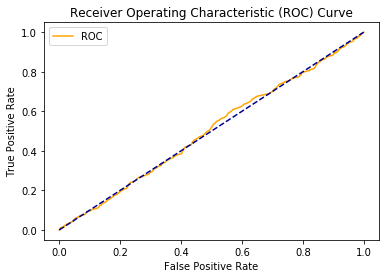

Finish [train]...


In [8]:
def main():
    #rawToRecord()
    #splitRecord()
    combineFiles()
    preprocess()
    features()
    train()


if __name__ == "__main__":
    main()